In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import datetime

In [ ]:
###################################################################################
###         convert dates and times of manual controls to timestamps            ###
###################################################################################

year = 2021
month = 5
day = [5, 5, 6, 7, 8, 9, 10, 11, 13, 18, 14]
hour = [0, 20, 10, 8, 10, 13, 9, 16, 11, 12, 0]
minutes = [13, 13, 46, 27, 40, 20, 0, 24, 50, 15, 0]
seconds = 0
timestamps = []

if len(day) == len(hour) == len(minutes):
    for i in range(len(day)):
        time = datetime(year, month, day[i], hour[i], minutes[i], seconds)
        timestamp = time.timestamp()
        timestamps.append(timestamp)
        print(time, 'hat den Timestamp', timestamp)

else:
    print('ungleiche Zahl an Tagen, Stunden & Minuten')

2021-05-05 00:13:00 hat den Timestamp 1620166380.0
2021-05-05 20:13:00 hat den Timestamp 1620238380.0
2021-05-06 10:46:00 hat den Timestamp 1620290760.0
2021-05-07 08:27:00 hat den Timestamp 1620368820.0
2021-05-08 10:40:00 hat den Timestamp 1620463200.0
2021-05-09 13:20:00 hat den Timestamp 1620559200.0
2021-05-10 09:00:00 hat den Timestamp 1620630000.0
2021-05-11 16:24:00 hat den Timestamp 1620743040.0
2021-05-13 11:50:00 hat den Timestamp 1620899400.0
2021-05-18 12:15:00 hat den Timestamp 1621332900.0
2021-05-14 00:00:00 hat den Timestamp 1620943200.0


In [ ]:
###################################################
###         read all data form log-file         ###
###################################################

file_data = 'C:\\Users\Jan\GitRepos\data\Sud1.json'

time=[]
pressure=[]
airflow=[]
with open (file_data) as f:
    for line in f:
        fermentation = json.loads(line)
        time.append(fermentation['Timestamp'])
        pressure_dict=fermentation['pressure']
        pressure.append(pressure_dict['bar'])
        airflow_dict = fermentation['airflow']
        airflow.append(airflow_dict['flow'])

###########################################################
###         transofrm data into numpy arrays            ###
###########################################################

time = np.array(time)
time = np.multiply(0.001, time).round(decimals=0)   # transform timestamps from milliseconds to seconds
pressure = np.array(pressure)
airflow = np.array(airflow)

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

time shape: (270352,)
pressure shape: (270352,)
airflow shape: (270352,)


In [ ]:
#######################################################
###         find first and last timestamp           ###
#######################################################

print(np.where(time==1620166381)[0][0])             # zeigt Position des ersten Wertes an -> bis hier werden die Werte der Arrays gelöscht
print(time[-1])                                     # zeigt dass die letzte digitale Messung vor der letzten Manuellen Messung stattfand -> Arrays bleiben bis zum Ende erhalten

38773
1621328577.0


In [ ]:
####################################################################################
###         delete first values of arrays before start of fermentation           ###
####################################################################################

time = time[38773:]
pressure = pressure[38773:]
airflow = airflow[38773:]
print(time[0])                                      # prüfe, dass wirklich mit richtigem timestamp gestartet wird

time = time.clip(min=0)                             # set negativ values to zero
pressure = pressure.clip(min=0)                     # set negativ values to zero
airflow[airflow < 20] = 0                           # set values smaller than 20 to zero

print('time shape:', time.shape)
print('pressure shape:', pressure.shape)
print('airflow shape:', airflow.shape)

1620166381.0
time shape: (231579,)
pressure shape: (231579,)
airflow shape: (231579,)


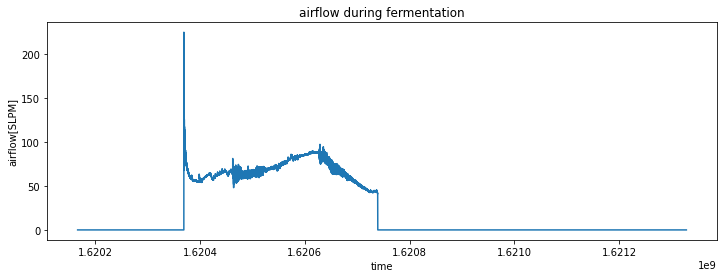

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time,airflow)
plt.xlabel('time')
plt.ylabel('airflow[SLPM]')
plt.show()

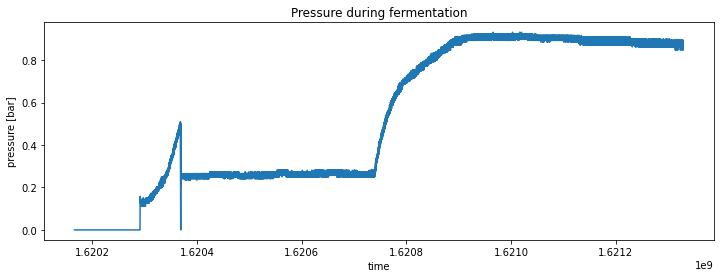

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Pressure during fermentation')
plt.plot(time, pressure)
plt.xlabel('time')
plt.ylabel('pressure [bar]')
plt.show()

In [ ]:
#########################################################
###         smoothing of airflow and pressure         ###
#########################################################

kernel_size = 10000
kernel = np.ones(kernel_size) / kernel_size
airflow = np.convolve(airflow, kernel, mode='same')
pressure = np.convolve(pressure, kernel, mode='same')

print('airflow shape:', airflow.shape)
print('pressure shape:', pressure.shape)

airflow shape: (231579,)
pressure shape: (231579,)


In [ ]:
#############################################################################
###         calculations with arrays for more detailed input data         ###
#############################################################################

time_seconds = time - 1620166380
time_days = np.multiply(1.157416667e-5, time_seconds).round(decimals=5)

# ----------------------------------------------------------------
airflow = np.multiply(0.08, airflow)
airflow = airflow.round(decimals=5)
airflow_5s = np.multiply(0.0833333333333, airflow).round(decimals=5)        # *(5/60) -> Standart Liter per 5 secondes
airflow_sum = np.cumsum(airflow_5s)                                         # sum up all values of airflow in airflow_sum
airflow_diff = np.diff(airflow_5s)                                          # difference of airflow values to the next one
airflow_diff = np.insert(airflow_diff, 0, 0)                                # insert beginning zero for same size of array

# ----------------------------------------------------------------
pressure = pressure.round(decimals=5)
pressure[156500:] = 0.91

# print(np.amax(pressure))
# print(pressure.argmax(axis=0))
# print(pressure[155062])



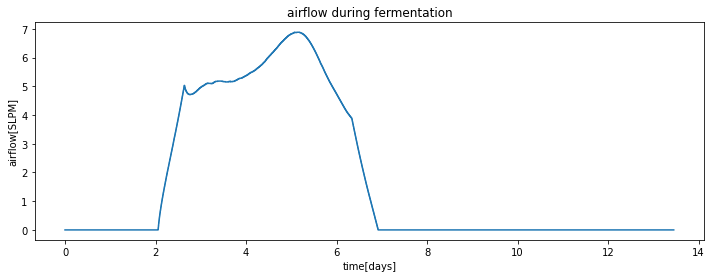

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow)
plt.xlabel('time[days]')
plt.ylabel('airflow[SLPM]')
plt.show()

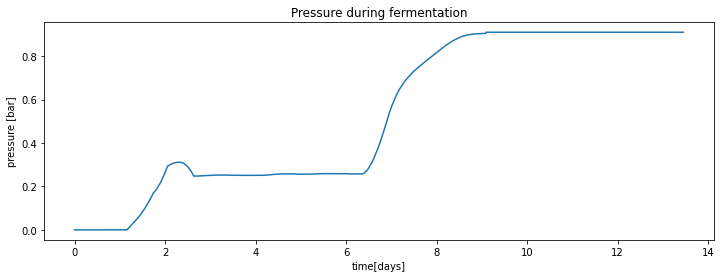

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Pressure during fermentation')
plt.plot(time_days, pressure)
plt.xlabel('time[days]')
plt.ylabel('pressure [bar]')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow during fermentation')
plt.plot(time_days,airflow_5s)
plt.xlabel('time[days]')
plt.ylabel('airflow[SL/5s]')
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.title('airflow_sum during fermentation')
plt.plot(time_days,airflow_sum)
plt.xlabel('time[days]')
plt.ylabel('airflow_sum[SL]')
plt.show()

In [ ]:
##########################################################################################
###         find position of current temperature, set temperature, set pressure        ###
##########################################################################################
 
print(np.where(time==1620238380)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 10°C und Ist_temperatur 9°C beträgt
print(np.where(time==1620743040)[0][0])             # zeigt Position des ersten Wertes an, an dem Soll-Temperatur 12°C und Soll-Druck 1,4 bar beträgt

print(np.where(time==1620290761)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 9,5°C beträgt
print(np.where(time==1620368820)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 10°C beträgt
print(np.where(time==1620899399)[0][0])             # zeigt Position des ersten Wertes an, an dem Ist-Temperatur 12°C beträgt

14342
114832
24766
40300
146003


In [ ]:
#######################################################################################################################
###         create arrays with same shape for current temperature, temperature setpoint & pressure setpoint         ###
#######################################################################################################################

temperature = np.full_like(time_days, 1)
temperature[:14342] = 20
temperature[14342:24766] = 9
temperature[24766:40300] = 9.5
temperature[40300:146003] = 10
temperature[146003:] = 12

print('temperature shape:', temperature.shape)
print('temperature:', temperature[:3])
print('temperature:', temperature[14340:14344])
print('temperature:', temperature[24764:24768])
print('temperature:', temperature[40298:40302])
print('temperature:', temperature[146001:146005])

# ----------------------------------------------------------------

temperature_set = np.full_like(time_days, 1)
temperature_set[:14342] = 8
temperature_set[14342:114832] = 10
temperature_set[114832:] = 12

print('temperature_set shape:', temperature_set.shape)
print('temperature_set:', temperature_set[:3])
print('temperature_set:', temperature_set[14340:14344])
print('temperature_set:', temperature_set[114830:114834])

# ----------------------------------------------------------------

pressure_set = np.full_like(time_days, 0)
pressure_set[114832:] = 1.4

print('pressure_set shape:', pressure_set.shape)
print('pressure_set:', pressure_set[:3])
print('pressure_set:', pressure_set[114830:114834])

temperature shape: (231579,)
temperature: [20. 20. 20.]
temperature: [20. 20.  9.  9.]
temperature: [9.  9.  9.5 9.5]
temperature: [ 9.5  9.5 10.  10. ]
temperature: [10. 10. 12. 12.]
temperature_set shape: (231579,)
temperature_set: [8. 8. 8.]
temperature_set: [ 8.  8. 10. 10.]
temperature_set: [10. 10. 12. 12.]
pressure_set shape: (231579,)
pressure_set: [0. 0. 0.]
pressure_set: [0.  0.  1.4 1.4]


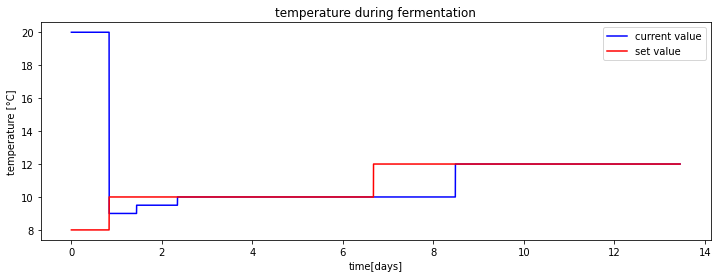

In [ ]:
plt.figure(figsize=(12,4))
plt.title('temperature during fermentation')
plt.plot(time_days, temperature, color="blue", label="current value")
plt.plot(time_days, temperature_set, color="red", label="set value")
plt.xlabel('time[days]')
plt.ylabel('temperature [°C]')
plt.legend()
plt.show()

In [ ]:
###########################################
###         Extraktberechnung           ###
###########################################

# ----------------------------------------------------------------
#           create arrays full of ones

flow_mass = np.full_like(time_days, 1)
flow_mass_total = np.full_like(time_days, 1)
air_mass = np.full_like(time_days, 1)
gas_in_liquid_mass = np.full_like(time_days, 1)
total_co2_mass = np.full_like(time_days, 1)
extract_mass_converted = np.full_like(time_days, 1)
extraktgehalt = np.full_like(time_days, 1)
extraktgehalt_scheinbar_1 = np.full_like(time_days, 1)
vergaerungsgrad = np.full_like(time_days, 1)
# ----------------------------------------------------------------
#           constants for fermentation calculation

SW = 11.9                                           # Stammwürze [°P]
wuerze_mass = 2096                                  # Masse der Würze vor der Gärung [kg]
wuerze_volume = 2                                   # Würzevloumen [m^3]
air_volume = 1000                                   # Luftvolumen [l]
extract_mass_start = SW * wuerze_mass / 100         # Startextrakt in [kg] aus Stammwürze und Masse der Würze
mol_mass = 44.01                                    # Molare Masse von CO2 in [g/mol]
henry_const = 0.0338                                # Henry-Konstante für CO2 [mol/(l*bar)]
q = (0.22 + (SW * 0.001))                           # Umrechnungsfaktor für wahren/scheinbaren Extraktgehalt

# ----------------------------------------------------------------------------------------
#           loop over every step (every 5 seconds) during fermantation

for i in range(len(extraktgehalt)):

    temperature_kelvin = temperature[i] + 273.15                                        # Temperatur [K]

    # ---------- ausströmendes CO2 ----------------------------------------------------------------------------------------------------------------
    # density = (pressure[i] * 100000) / (188.9 * (temperature_kelvin))                   # Dichte aus iG-Gesetz [kg/m^3] (100000 - Umrechnung Pascal, 188.9 - Gaskonstante CO2)
    # density = (pressure[i] * 100000) / (188.9 * 273.15)
    density = 1.98
    flow_mass[i] = airflow_5s[i] * density * 0.001                                      # Masse des Durchfluss der letzten 5s [kg]
    if i == 0:
        flow_mass_total[i] = flow_mass[i]
    else:    
        flow_mass_total[i] = flow_mass_total[i-1] + flow_mass[i]                        # gesamtes ausgeströmtes CO2 [kg]
    
    # ---------- im Bier gelöstes CO2 -------------------------------------------------------------------------------------------------------------
    temp_compensation = math.exp(2400 * ((1/temperature_kelvin) - (1/298.15) ))         # Temperaturkompensation für Henrygesetz errechnen
    henry_coefficient = henry_const * temp_compensation                                 # Henry-Koeffizient für CO2 [mol/(l*bar)]
    CO2__concentration = henry_coefficient * pressure[i]                                # Stoffkonzentration in Flüssigkeit über Henry-Gesetz [mol/l]
    gas_in_liquid_mass[i] = mol_mass * wuerze_volume * CO2__concentration               # CO2 im Bier gelöst [kg]

    # ---------- im Tank über dem Bier stehendes CO2 ----------------------------------------------------------------------------------------------
    air_mass[i] = (pressure[i] *100000  * air_volume * 0.001) / (188.9 * temperature_kelvin)      # CO2 im Tank iG-Gesetz [kg] (Beachte Umrechnung bar -> Pa, l -> m^3)
    
    # ---------- GESAMT ---------------------------------------------------------------------------------------------------------------------------
    total_co2_mass[i] = flow_mass_total[i] + air_mass[i] + gas_in_liquid_mass[i]                                        # gesamt erzeugtes CO2 [kg]
    extract_mass_converted[i] = total_co2_mass[i] * 2.1605                                                             # umgesetzter Extrakt [kg]
    vergaerungsgrad[i] = extract_mass_converted[i] / extract_mass_start
    extraktgehalt[i] = SW - (vergaerungsgrad[i] * SW)
    # extraktgehalt[i] = (extract_mass_start - extract_mass_converted[i]) * 100 / (wuerze_mass - (flow_mass_total[i] + air_mass[i]))      # Restextraktgehalt [°P]
    extraktgehalt_scheinbar_1[i] = (extraktgehalt[i] - (0.1808*SW))/0.8192                                                 # scheinbarer Extraktgehalt [°P]

print('mass extract before fermantation:', extract_mass_start, 'kg \n')
print('mass of total CO2 flow (outside tank) after fermantation:', flow_mass_total[-1], 'kg')
print('mass of CO2 above liquid in tank:', air_mass[-1], 'kg')
print('mass of CO2 in liquid after fermantation:', gas_in_liquid_mass[-1], 'kg')
print('total mass of CO2 after fermantation:', total_co2_mass[-1], 'kg \n')
print('Vergaerungsgrad:', vergaerungsgrad[-1], '\n')
print('Extraktgehalt shape:', extraktgehalt.shape)
print('Extraktgehalt Start:', extraktgehalt[0])
print('Extraktgehalt Ende:', extraktgehalt[-1])
print('Extraktgehalt scheinbar Ende:', extraktgehalt_scheinbar_1[-1])



mass extract before fermantation: 249.424 kg 

mass of total CO2 flow (outside tank) after fermantation: 65.56472999999154 kg
mass of CO2 above liquid in tank: 1.6894138819881284 kg
mass of CO2 in liquid after fermantation: 3.9076739226364197 kg
total mass of CO2 after fermantation: 71.16181780461609 kg 

Vergaerungsgrad: 0.6164006164878804 

Extraktgehalt shape: (231579,)
Extraktgehalt Start: 11.9
Extraktgehalt Ende: 4.564832663794224
Extraktgehalt scheinbar Ende: 2.9459383102956833


In [ ]:
###########################################
###         plot data over time         ###
###########################################

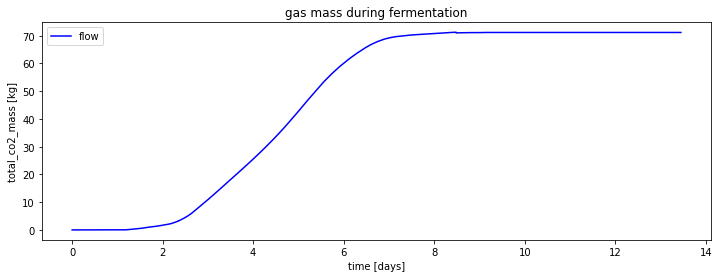

In [ ]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, total_co2_mass, color="blue", label="flow")
plt.xlabel('time [days]')
plt.ylabel('total_co2_mass [kg]')
plt.legend()
plt.show()

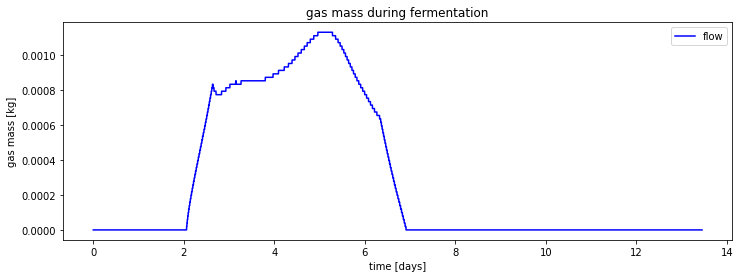

In [ ]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, flow_mass, color="blue", label="flow")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

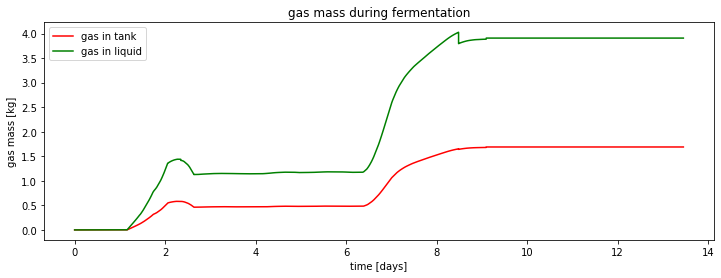

In [ ]:
plt.figure(figsize=(12,4))
plt.title('gas mass during fermentation')
plt.plot(time_days, air_mass, color="red", label="gas in tank")
plt.plot(time_days, gas_in_liquid_mass, color="green", label="gas in liquid")
plt.xlabel('time [days]')
plt.ylabel('gas mass [kg]')
plt.legend()
plt.show()

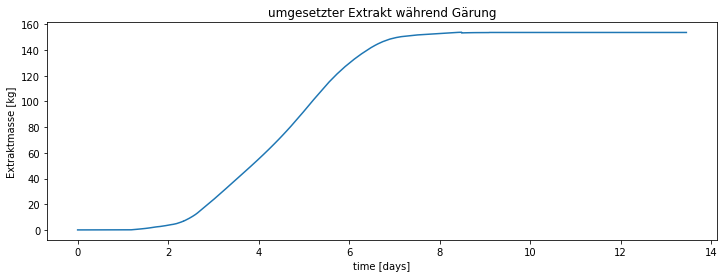

In [ ]:
plt.figure(figsize=(12,4))
plt.title('umgesetzter Extrakt während Gärung')
plt.plot(time_days, extract_mass_converted)
plt.xlabel('time [days]')
plt.ylabel('Extraktmasse [kg]')
plt.show()

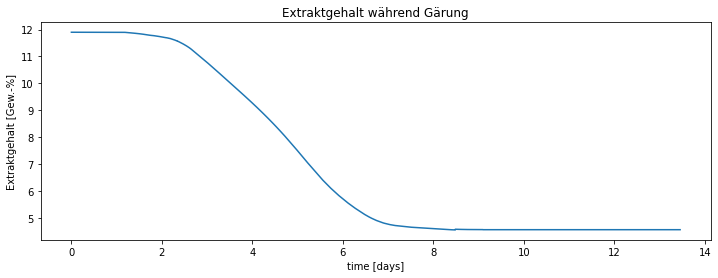

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()

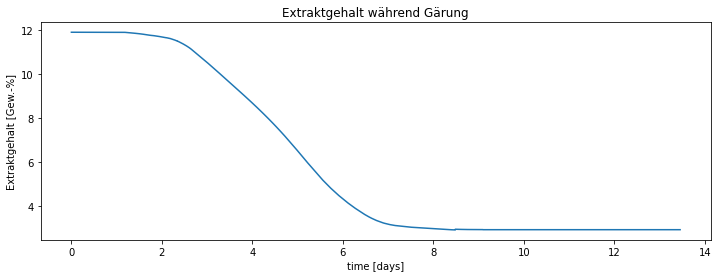

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Extraktgehalt während Gärung')
plt.plot(time_days, extraktgehalt_scheinbar_1)
plt.xlabel('time [days]')
plt.ylabel('Extraktgehalt [Gew.-%]')
plt.show()